In [2]:
import sys
sys.path.insert(1, '/cis/home/adesilva/ashwin/research/ood-tl')

from datahandlers.pacs import PACSHandler

import numpy as np
import omegaconf
from imshowtools import imshow
from PIL import Image
from copy import deepcopy
from sklearn.metrics import pairwise_kernels, pairwise_distances

import torch
import torch.nn as nn
import torchvision
from torch.cuda.amp import autocast

import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools

In [3]:
seed = 1996
rng = np.random.default_rng(seed)
true_seed = int(rng.integers(2**30))

np.random.seed(true_seed)
np.random.seed(true_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(true_seed)
torch.cuda.manual_seed_all(true_seed)

In [4]:
# misc functions

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


def visualize_samples(loader, idx):
    samples = []
    path_list = loader.dataset.data[idx]
    for path in path_list:
        im = np.asarray(Image.open(path[0]))
        samples.append(im)
    samples = np.array(samples)
    imshow(*samples)

In [5]:
# Kernel two-sample test functions

def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic.
    """
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
        1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
        2.0 / (m * n) * Kxy.sum()


def compute_null_distribution(K, m, n, iterations=10000, verbose=False,
                              random_state=None, marker_interval=1000):
    """Compute the bootstrap null-distribution of MMD2u.
    """
    if type(random_state) == type(np.random.RandomState()):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        if verbose and (i % marker_interval) == 0:
            print(i),
            stdout.flush()
        idx = rng.permutation(m+n)
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    if verbose:
        print("")

    return mmd2u_null


def compute_null_distribution_given_permutations(K, m, n, permutation,
                                                 iterations=None):
    """Compute the bootstrap null-distribution of MMD2u given
    predefined permutations.
    Note:: verbosity is removed to improve speed.
    """
    if iterations is None:
        iterations = len(permutation)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        idx = permutation[i]
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    return mmd2u_null


def kernel_two_sample_test(X, Y, kernel_function='rbf', iterations=10000,
                           verbose=False, random_state=None, **kwargs):
    """Compute MMD^2_u, its null distribution and the p-value of the
    kernel two-sample test.
    Note that extra parameters captured by **kwargs will be passed to
    pairwise_kernels() as kernel parameters. E.g. if
    kernel_two_sample_test(..., kernel_function='rbf', gamma=0.1),
    then this will result in getting the kernel through
    kernel_function(metric='rbf', gamma=0.1).
    """
    m = len(X)
    n = len(Y)
    XY = np.vstack([X, Y])
    K = pairwise_kernels(XY, metric=kernel_function, **kwargs)
    mmd2u = MMD2u(K, m, n)
    if verbose:
        print("MMD^2_u = %s" % mmd2u)
        print("Computing the null distribution.")

    mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=verbose,
                                           random_state=random_state)
    p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
    if verbose:
        print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))

    return mmd2u, mmd2u_null, p_value

In [6]:
# get feature matrix from pretrained model
def get_feature_mat(model, loader, num_features, gpu=1):
    device = torch.device("cuda:{}".format(gpu))
    model.to(device)
    model.eval()
    feature_mat = torch.zeros((len(loader.dataset), num_features))
    class_labs = torch.zeros(len(loader.dataset))
    with torch.no_grad():
        for ims, targets, ids in loader:
            ims = ims.to(device)
            _ , labs = targets
            labs = labs.to(device)
            with autocast():
                out = model(ims)
                feature_mat[ids.squeeze(-1)] = out.squeeze().float().cpu()
                class_labs[ids.squeeze(-1)] = labs.squeeze().float().cpu()
    return feature_mat, class_labs

# define the iteration
def iteration(D_0, D_1, num_samples_per_iter, sig_level=0.05):
    idx = np.random.choice(len(D_1), num_samples_per_iter, replace=False)
    S = D_1[idx]
    sigma2 = np.median(pairwise_distances(D_0, S, metric='euclidean'))**2
    t, _ , p_value =  kernel_two_sample_test(D_0, S, kernel_function='rbf', gamma=1.0/sigma2)
    weights = np.zeros(len(D_1))
    if p_value < sig_level:
        weights[idx] = t / num_samples_per_iter
    return weights

In [7]:
# set params

# dataset params
n0 = 30
n1 = 10
m_n = 0.2
ood_fraction = 1/6

# OOD detection params
num_samples_per_iter = 4
max_iter = 2000

# other
seed = 3000
batchsize = 16

In [8]:
cfg = omegaconf.OmegaConf.load("/cis/home/adesilva/ashwin/research/ood-tl/config/conf.yaml")
cfg.task.target_env = 'P'       # number of total samples in the dataset: 590 (147 + 443)
cfg.task.ood_env = 'S'          # number of total samples in the dataset: 2328
cfg.task.task_map = [[0,1,4]]
cfg.task.n = n1
cfg.task.m_n = m_n
cfg.hp.bs = batchsize
dataHandler = PACSHandler(cfg)
dataHandler.sample_data(seed)

targets = np.array(dataHandler.testset.targets)
indices = []
for lab in range(len(cfg.task.task_map[0])):
    class_indices = np.where(targets[:, 1] == lab)[0]
    indices.extend(np.random.choice(class_indices, n0))
dataHandler.testset.data = dataHandler.testset.data[indices]
dataHandler.testset.targets = targets[indices].tolist()

day0_loader = dataHandler.get_data_loader(train=False) # only comprises of target data
day1_loader = dataHandler.get_data_loader(train=True)  # comprises of target data and a known fraction of OOD data

In [9]:
# Obtain the featurizer from the pre-trained ResNet-18 model
ptmodel = torchvision.models.resnet18(pretrained=True)
num_features = ptmodel.fc.in_features
for param in ptmodel.parameters():
    param.requires_grad = False
featurizer = nn.Sequential(*list(ptmodel.children())[:-1])

In [10]:
# Obtain the feature matrices
day0_mat, _ = get_feature_mat(featurizer, day0_loader, num_features)
day1_mat, _ = get_feature_mat(featurizer, day1_loader, num_features)

In [11]:
# compute the weights for each iteration
f = lambda : iteration(day0_mat, day1_mat, num_samples_per_iter)

with tqdm_joblib(tqdm(desc="Running iterations...", total=max_iter, position=0, leave=True)) as progress_bar:
    all_weights = np.array(Parallel(n_jobs=-1)(delayed(f)() for i in range(max_iter)))

Running iterations...:  16%|█▌        | 314/2000 [00:21<01:54, 14.73it/s]


KeyboardInterrupt: 

In [ ]:
# get the predicted OOD sample indices
total_samples = len(day1_mat)
weight_per_sample = np.mean(all_weights, axis=0)
sorted_idx = np.argsort(weight_per_sample)
predicted_ood_idx = sorted_idx[-int(ood_fraction * total_samples):]

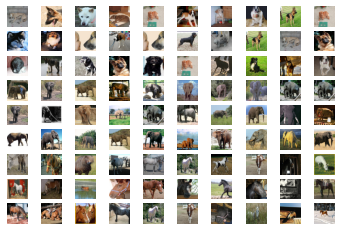

In [ ]:
# visualize the samples from day0
visualize_samples(day0_loader, np.arange(len(day0_mat)))

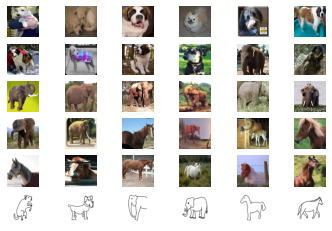

In [ ]:
# visualize the samples from day1
visualize_samples(day1_loader, np.arange(len(day1_mat)))

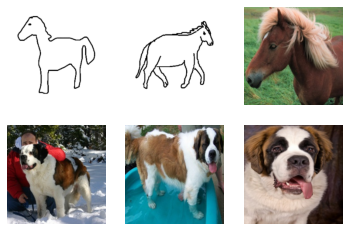

In [ ]:
# visualize the proposed OOD samples
visualize_samples(day1_loader, predicted_ood_idx)